In [1]:



import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torchvision
import torchvision.models as models
import sys
    # caution: path[0] is reserved for script path (or '' in REPL)
from torch import Tensor

import json
import numpy as np
import os
import pandas as pd
import re

import matplotlib.pyplot as plt

In [3]:
#create training plot



output = torch.load('saved_output/vgg16_new_validating_output/output_e0_b64')

model_name = "vgg19_pretrained"

In [4]:
#find max epoch and max batch  
output_files = [ i for i in os.listdir(f'saved_output/{model_name}_validating_output/') if 'output' in i]
output_files
max_b=0
max_e = 0
for output_file in output_files:
    of = re.findall('\d+$',output_file)
    if int(of[0]) > max_b:
        max_b = int(of[0])
    a= output_file.split('_')
    if int(a[1][1:]) >= max_e:
        max_e = int(a[1][1:])
    



def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred_t = pred.t()

    correct = pred_t.eq(target.view(1, -1).expand_as(pred_t))

    nb_classes = 185

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    _, preds = torch.max(output, 1)
    
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # print(confusion_matrix)
    
    
    # print(confusion_matrix.diag()/confusion_matrix.sum(1))
        
    res = []
    for k in topk:
    	correct_k = torch.sum(torch.reshape(correct[:k],(-1,) ).float()) #.double().sum(0)
    	res.append(correct_k.mul_(100.0 / batch_size))
    res.append(confusion_matrix)
    return res


In [229]:
prec1_list = []
prec1_avg_list = []
prec1_avg_list_temp = []
prec5_list = []
prec5_avg_list = []
prec5_avg_list_temp = []

best_epoch = 0
best_epoch_avg = 0

best_epoch_avg_5 = 0
for e in range(max_e+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        
        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))

        prec1_list.append(prec1.cpu())
        prec1_avg_list_temp.append(prec1.cpu())

        prec5_list.append(prec5.cpu())
        prec5_avg_list_temp.append(prec5.cpu())
    
    if best_epoch_avg < np.average(prec1_avg_list_temp):
        best_epoch_avg = np.average(prec1_avg_list_temp)
        best_epoch = e
        best_epoch_avg_5 =np.average(prec5_avg_list_temp)
        
    prec1_avg_list.append(np.average((prec1_avg_list_temp)))
    prec1_avg_list_temp = []


    prec5_avg_list.append(np.average(prec5_avg_list_temp))
    prec5_avg_list_temp = []
    
print('best epoch')
print(best_epoch,best_epoch_avg,'prec5:',best_epoch_avg_5)

best epoch
38 92.383514 prec5: 98.991936


In [5]:
prec1_array = np.array(prec1_list)
prec1_array_avg = np.array(prec1_avg_list)

prec5_array = np.array(prec5_list)
prec5_array_avg = np.array(prec5_avg_list)

NameError: name 'prec1_list' is not defined

In [ ]:
xticks_size = 20
yticks_size = 20
ylabel_size = 30
xlabel_size = 30 
title_size = 40
linewidth = 4

xticks = [5,10,15,20,25,30,35,38]


plt.figure(figsize=(20,10))

x = [i for i in range(len(prec1_array_avg[:39]))]
# plt.axvline(x = 15, color = 'r', label = 'axvline - full height')
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 0, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 1', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, 39])
plt.ylim([0, 100])
plt.plot(x,prec1_array_avg[:39], linewidth = linewidth)

In [ ]:
plt.figure(figsize=(20,10))
x = [i for i in range(len(prec5_array_avg))]
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 20, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 5', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, max_e])
plt.ylim([0, 100])
plt.plot(x,prec5_array_avg, linewidth = linewidth)

In [11]:
##Loading data points
from pyproj import Proj, transform
import scipy.spatial as spatial

def convert_utm_to_latlon(df, zone_number, zone_letter):
    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', south=(zone_letter < 'N'))
    lonlat_proj = Proj(proj='latlong', datum='WGS84')
    lon, lat = transform(utm_proj, lonlat_proj, df['Østkoordinat'].values, df['Nordkoordinat'].values)
    
    return pd.DataFrame({'Longitude': lon, 'Latitude': lat})



dat = pd.read_csv('C:/Users/vjosv/master/dataset/top185_in_oslo_area.csv')
dat = dat[['Id','Østkoordinat','Nordkoordinat','Vitenskapelig navn']]




dat['points']= [[i,j] for i, j in zip(dat.Østkoordinat, dat.Nordkoordinat)]

df_latlon = convert_utm_to_latlon(dat, 33, 'N') 


dat['lat']=df_latlon['Latitude']
dat['long']=df_latlon['Longitude']



#oslo area:
#lowerleft, upperleft, upper right, lower right,


lat_long_oslo = [(58.998141, 9.574585), (60.351413, 9.574585), (60.351413, 12.540894),(58.998141,12.540894)]

# dat['Østkoordinat']>lat_long_oslo[0][0]


dat = dat.loc[(dat['lat']>lat_long_oslo[0][0])  & (dat['lat']<lat_long_oslo[1][0]) & (dat['long']>lat_long_oslo[0][1 ]) & (dat['long']<lat_long_oslo[2][1])]





points = dat[['Østkoordinat','Nordkoordinat']].to_numpy()




point_tree = spatial.cKDTree(points)


science_names = dat['Vitenskapelig navn'].unique()
indexes = [i for i in range(len(dat['Vitenskapelig navn'].unique()))]



C:\Users\vjosv\AppData\Local\Temp\ipykernel_21484\1158250730.py:14: DtypeWarning: Columns (14,15,24,25,26,37,38,39,40,46) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('C:/Users/vjosv/master/dataset/top185_in_oslo_area.csv')


KeyboardInterrupt: 

In [7]:
# knn

output = torch.load('saved_output/vgg16_new_validating_output/output_e0_b64')

model_name = "vgg19_pretrained"

list_outputs = os.listdir(f'saved_output/{model_name}_validating_output/')


In [8]:
kde_outputs = []
for lo in list_outputs:
    if lo[:3] == 'kde':
        kde_outputs.append(lo)

In [ ]:
import geopy.distance
for i in side_len:
    a = points[0][0]+i
    b = points[0][0]-i
    zone_number = 33
    zone_letter = 'N'
    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', south=(zone_letter < 'N'))
    lonlat_proj = Proj(proj='latlong', datum='WGS84')

    lon1, lat1 = transform(utm_proj, lonlat_proj, a, points[0][1])

    lon, lat = transform(utm_proj, lonlat_proj, b, points[0][1])
    print(geopy.distance.geodesic((lat1,lon1), (lat,lon)).km)
    
    a = points[0][1]+i
    b = points[0][1]-i
    zone_number = 33
    zone_letter = 'N'
    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', south=(zone_letter < 'N'))
    lonlat_proj = Proj(proj='latlong', datum='WGS84')

    lon1, lat1 = transform(utm_proj, lonlat_proj, points[0][0],a)

    lon, lat = transform(utm_proj, lonlat_proj, points[0][0], b)


    
    print(geopy.distance.geodesic((lat1,lon1), (lat,lon)).km)

In [289]:

(lat1+0.5,lon1)
print(geopy.distance.geodesic((lat1,lon1), (lat1+1.5,lon1)).m)

167136.93886751446


In [49]:
kde_outputs[0]

side_len = [1000,2000,3000,4000]
bandwidth = [500,1000,1500, 2000,3000,4000]
configuration =[0,1,2]

def augment_output_add(output, augment, add):
    output_ = torch.nn.functional.softmax(output, dim=1)
    augment = augment/augment.sum(dim=1, keepdim=True)
    output_aug = output_ + add*augment
    output_aug = output_aug * 1/output_aug.sum(dim=1, keepdim=True)
    
    return torch.log(output_aug)



In [215]:
prec1_list = [[],[],[],[]]
prec1_avg_list_aug = [[],[],[],[]]
prec1_avg_list_temp = [[],[],[],[]]



prec5_list = [[],[],[],[]]
prec5_avg_list_aug = [[],[],[],[]]
prec5_avg_list_temp = [[],[],[],[]]


model_name2 ="resnet101_pretrained"

add = 1.7
max_epoch = 44

avg_prec1 =[]
avg_prec1_temp =[]
for e in range(max_epoch+1):#max_e+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_name2}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name2}_validating_output/target_b{b}')


        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
        avg_prec1_temp.append(prec1.cpu())
    avg_prec1.append(np.average(avg_prec1_temp))
    avg_prec1_temp =[]


best_epoch = np.argmax(avg_prec1)

           # print(dict_df)
dict_example = {'Side Length': [],
            'Bandwidth': [],
             'best epoch$_a$': [],
             'prec1$_a$ max': [],
            'prec1 at epoch$_a$':[],
            'prec5 at epoch$_a$':[],
            'prec5$_a$ at epoch$_a$':[],
            f'prec1$_a$ at epoch {best_epoch}':[],
            f'prec5$_a$ at epoch {best_epoch}':[],
           }

dict_df = [copy.deepcopy(dict_example) for i in range(4)]


           

def augment_output_add(output, augment, add):
    output_ = torch.nn.functional.softmax(output, dim=1)
    augment = augment/augment.sum(dim=1, keepdim=True)
    output_aug = output_ + add*augment
    output_aug = output_aug/output_aug.sum(dim=1,keepdim=True)
    
    return torch.log(output_aug)


max_e
add_list = [0.2]#,0.4,0.6,0.8,1]
add = 0.2

for sl in side_len:
    for bw in bandwidth:

        prec1_list = []
        prec1_list_aug = []
        prec1_avg_list_aug = []
        prec1_avg_list_aug_temp = []

        prec5_list = []
        prec5_list_aug = []
        prec5_avg_list_aug = []
        prec5_avg_list_aug_temp = []

        # prec5_avg_list = []
        # prec5_avg_list_temp = []

        # prec1_avg_list = []
        prec1_avg_list_temp=[]

        # prec1_avg_list = []
        for i in range(4):
            prec1_list.append([])
            prec1_list_aug.append([])
            prec1_avg_list_aug.append([])
            prec1_avg_list_aug_temp.append([])



            prec5_list.append([])
            prec5_list_aug.append([])
            prec5_avg_list_aug.append([])
            # prec5_avg_list_temp.append([])
            prec5_avg_list_aug_temp.append([])

            # prec1_avg_list.append([])
            prec1_avg_list_temp.append([])
            # prec5_avg_list.append([])
            prec5_avg_list_temp.append([])


#         for i in configuration:
#             for e in range(max_e+1):
#                 for b in range(max_b+1):
#                     output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
#                     target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

#                     tensor_list = []
#                     load_tensor =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{i}')
#                     tensor_list.append(load_tensor.cuda())
#                     # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

#                     output = augment_output_add(output,load_tensor.cuda(),add)


#                     prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
#                     prec1_list[i].append(prec1.cpu())
#                     prec1_avg_list_temp[i].append(prec1.cpu())

#                     prec5_list[i].append(prec5.cpu())
#                     prec5_avg_list_temp[i].append(prec5.cpu())



#                 # print(np.average(prec1_avg_list_temp))
#                 prec1_avg_list_aug[i].append(np.average((prec1_avg_list_temp[i])))
#                 prec1_avg_list_temp[i] = []


#                 prec5_avg_list_aug[i].append(np.average((prec5_avg_list_temp[i])))
#                 prec5_avg_list_temp[i] = []





        e = max_e
        for e in range(max_e+1):
            for b in range(max_b+1):
                output = torch.load(f'saved_output/{model_name2}_validating_output/output_e{e}_b{b}')
                target = torch.load(f'saved_output/{model_name2}_validating_output/target_b{b}')

                tensor_list = []


                load_tensor0 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{0}')
                load_tensor1 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{1}')
                load_tensor2 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{2}')

                try:
                    load_tensor0 = load_tensor0*1/torch.sum(load_tensor0)

                except:
                    print('f')
                    pass
                try:
                    load_tensor1 = load_tensor1*1/torch.sum(load_tensor1)
                except:
                    print('f')
                    pass
                try:
                    load_tensor2 = load_tensor2*1/torch.sum(load_tensor2)
                except:
                    print('f')
                    pass


                output0 = augment_output_add(output,load_tensor0.cuda(),add)
                output1 = augment_output_add(output,load_tensor1.cuda(),add)
                output2 = augment_output_add(output,load_tensor2.cuda(),add)


                prec10, prec50, conf1 = accuracy(output0.data, target, topk=(1, 5))
                prec11, prec51, conf1 = accuracy(output1.data, target, topk=(1, 5))
                prec12, prec52, conf1 = accuracy(output2.data, target, topk=(1, 5))

                prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
                # print(output0)
                prec1_avg = (prec10+prec11+prec12)/3
                # print(prec1_avg)
                # print('...........')
                prec5_avg = (prec50+prec51+prec52)/3






                prec1_list[3].append(prec1_avg.cpu())
                prec1_avg_list_temp[3].append(prec1_avg.cpu())

                prec5_list[3].append(prec5_avg.cpu())
                prec5_avg_list_temp[3].append(prec5_avg.cpu())



            print(np.average(prec1_avg_list_temp[3]),sl,bw,add)
            prec1_avg_list_aug[3].append(np.average((prec1_avg_list_temp[3])))
            prec1_avg_list_temp[3] = []

            prec5_avg_list_aug[3].append(np.average((prec5_avg_list_temp[3])))
            prec5_avg_list_temp[3] = []

        for i in [3]:#configuration +[3]:

           # print(dict_df)
            # print(i)
            # print(dict_df[i])
            dict_df[i]['Side Length'].append(sl)
            dict_df[i]['Bandwidth'].append(bw)
            dict_df[i]['best epoch$_a$'].append(np.argmax(prec1_avg_list_aug[i]))
            dict_df[i]['prec1$_a$ max'].append(np.max(prec1_avg_list_aug[i]))
            dict_df[i]['prec1 at epoch$_a$'].append(prec1_avg_list[np.argmax(prec1_avg_list_aug[i])])
            dict_df[i]['prec5 at epoch$_a$'].append(prec5_avg_list[np.argmax(prec1_avg_list_aug[i])])
            dict_df[i]['prec5$_a$ at epoch$_a$'].append(prec5_avg_list_aug[i][np.argmax(prec1_avg_list_aug[i])])
            # print(prec1_avg_list_aug)
            dict_df[i][f'prec1$_a$ at epoch {best_epoch}'].append(prec1_avg_list_aug[i][best_epoch])
            dict_df[i][f'prec5$_a$ at epoch {best_epoch}'].append(prec5_avg_list_aug[i][best_epoch])
            # print(prec5_avg_list_aug[i])
            print(f'radius {sr},bw:configuration {i}: best prec1 {np.max(prec1_avg_list_aug[i])} at epoch {np.argmax(prec1_avg_list_aug[i])},value {np.max(prec1_avg_list_aug[i][best_epoch])} at best epoch ')
            print(f'radius {sr},bw:configuration {i}: best prec5 {np.max(prec5_avg_list_aug[i])} at epoch {np.argmax(prec5_avg_list_aug[i])},value {np.max(prec5_avg_list_aug[i][best_epoch])} at best epoch ')
            print('\n')
            print(prec1_avg_list[np.argmax(prec1_avg_list_aug[i])])


8.816832 1000 500 0.2
10.026509 1000 500 0.2
9.916368 1000 500 0.2
10.523074 1000 500 0.2
10.859096 1000 500 0.2
10.259857 1000 500 0.2
10.937501 1000 500 0.2
10.79189 1000 500 0.2
11.111112 1000 500 0.2
11.202584 1000 500 0.2
11.157781 1000 500 0.2
11.073776 1000 500 0.2
11.26232 1000 500 0.2
11.262321 1000 500 0.2
11.379928 1000 500 0.2
11.603942 1000 500 0.2
11.592742 1000 500 0.2
11.626344 1000 500 0.2
11.598341 1000 500 0.2
11.682348 1000 500 0.2
11.615143 1000 500 0.2
11.603942 1000 500 0.2
11.631945 1000 500 0.2
11.620744 1000 500 0.2
11.592742 1000 500 0.2
11.620744 1000 500 0.2
11.620744 1000 500 0.2
11.626343 1000 500 0.2
11.620742 1000 500 0.2
11.598343 1000 500 0.2
11.626344 1000 500 0.2
11.631944 1000 500 0.2
11.648745 1000 500 0.2
11.682346 1000 500 0.2
11.637545 1000 500 0.2
11.598341 1000 500 0.2
11.631944 1000 500 0.2
11.626344 1000 500 0.2
11.643146 1000 500 0.2
11.665547 1000 500 0.2
11.631944 1000 500 0.2
11.648745 1000 500 0.2
11.620744 1000 500 0.2
11.659946 1000 

In [217]:
# print(dict_df[20])
# # prec1_avg_list_aug
dict_df[3]['prec1$_a$-prec1']= [dict_df[3]['prec1$_a$ max'][i] - dict_df[3]['prec1 at epoch$_a$'][i] for i in range(len(dict_df[3]['prec1 at epoch$_a$']))]
dict_df[3]['prec5$_a$-prec5']= [dict_df[3]['prec5$_a$ at epoch$_a$'][i] - dict_df[3]['prec5 at epoch$_a$'][i] for i in range(len(dict_df[3]['prec1 at epoch$_a$']))]
                                         
# dict_df[3]['prec5$_a$-prec5']= [dict_df[3]['prec5 at best epoch'][i] - dict_df[3]['original prec5 at aug max'][i] for i in range(len(dict_df[3]['original prec5 at aug max']))]
                                      
# dict_df[20]['prec5$_a$ at epoch 26'] = dict_df[20]['prec1 at epoch$_a$']                             
                                      
# dict_df                                 
b = pd.DataFrame.from_dict(dict_df[3] )
# a

print(b[['Side Length', 'Bandwidth','best epoch$_a$','prec1$_a$ max','prec5$_a$ at epoch$_a$','prec1$_a$-prec1','prec5$_a$-prec5' ]].to_latex(index=False))
# print(a.to_latex(index=False))
# dict_df[20]
b.to_csv(f'kde_radius{model_2}_results1.csv')
# a

\begin{tabular}{rrrrrrr}
\toprule
Side Length & Bandwidth & best epoch$_a$ & prec1$_a$ max & prec5$_a$ at epoch$_a$ & prec1$_a$-prec1 & prec5$_a$-prec5 \\
\midrule
1000 & 500 & 19 & 11.682348 & 13.644340 & -81.093185 & -85.734016 \\
1000 & 1000 & 19 & 32.256199 & 34.649418 & -60.519337 & -64.728943 \\
1000 & 1500 & 19 & 53.772770 & 56.839912 & -39.002766 & -42.538445 \\
1000 & 2000 & 19 & 71.397110 & 75.153084 & -21.378426 & -24.225273 \\
1000 & 3000 & 33 & 90.552200 & 95.026878 & -2.385750 & -4.385086 \\
1000 & 4000 & 23 & 94.013222 & 98.728729 & 0.935265 & -0.649628 \\
2000 & 500 & 33 & 12.725883 & 14.760675 & -80.212067 & -84.651291 \\
2000 & 1000 & 19 & 33.594685 & 36.055111 & -59.180851 & -63.323246 \\
2000 & 1500 & 19 & 55.055256 & 58.234402 & -37.720280 & -41.143955 \\
2000 & 2000 & 19 & 72.295029 & 76.022995 & -20.480507 & -23.355362 \\
2000 & 3000 & 33 & 90.822884 & 95.336777 & -2.115067 & -4.075188 \\
2000 & 4000 & 33 & 94.018829 & 98.745529 & 1.080879 & -0.666435 \\
3000 & 5

In [205]:
dict_df

[{'Side Length': [],
  'Bandwidth': [],
  'best epoch$_a$': [],
  'prec1$_a$ max': [],
  'prec1 at epoch$_a$': [],
  'prec5 at epoch$_a$': [],
  'prec5$_a$ at epoch$_a$': [],
  'prec1$_a$ at epoch 26': [],
  'prec5$_a$ at epoch 26': []},
 {'Side Length': [],
  'Bandwidth': [],
  'best epoch$_a$': [],
  'prec1$_a$ max': [],
  'prec1 at epoch$_a$': [],
  'prec5 at epoch$_a$': [],
  'prec5$_a$ at epoch$_a$': [],
  'prec1$_a$ at epoch 26': [],
  'prec5$_a$ at epoch 26': []},
 {'Side Length': [],
  'Bandwidth': [],
  'best epoch$_a$': [],
  'prec1$_a$ max': [],
  'prec1 at epoch$_a$': [],
  'prec5 at epoch$_a$': [],
  'prec5$_a$ at epoch$_a$': [],
  'prec1$_a$ at epoch 26': [],
  'prec5$_a$ at epoch 26': []},
 {'Side Length': [1000, 2000, 3000, 4000],
  'Bandwidth': [4000, 4000, 4000, 4000],
  'best epoch$_a$': [26, 26, 26, 26],
  'prec1$_a$ max': [93.32438, 93.31878, 93.32438, 93.32438],
  'prec1 at epoch$_a$': [93.07796, 93.07796, 93.07796, 93.07796],
  'prec5 at epoch$_a$': [99.462364, 9

In [16]:
#print as latex table 
for i in [3]:#configuration+[3]:
    a = pd.DataFrame.from_dict(dict_df[i])
    print(a.to_latex())
    
    a.to_csv(f'kde_results_configuration{i}.csv')

\begin{tabular}{lrrrrrr}
\toprule
 & Side Length & Bandwidth & best epoch & prec1 max & prec5 at best epoch & prec1 at epoch 38 \\
\midrule
\bottomrule
\end{tabular}



In [29]:
knn_outputs = []
for lo in list_outputs:
    if lo[:3] == 'knn':
        knn_outputs.append(lo)
print(knn_outputs[:10])


configurations = [0,1,2]

n_list = [25,50,75,100,200,500,1000,1500,2000,2500,3000]



['knn_smote_n_1000_batch0_cofiguration0', 'knn_smote_n_1000_batch0_cofiguration1', 'knn_smote_n_1000_batch0_cofiguration2', 'knn_smote_n_1000_batch10_cofiguration0', 'knn_smote_n_1000_batch10_cofiguration1', 'knn_smote_n_1000_batch10_cofiguration2', 'knn_smote_n_1000_batch11_cofiguration0', 'knn_smote_n_1000_batch11_cofiguration1', 'knn_smote_n_1000_batch11_cofiguration2', 'knn_smote_n_1000_batch12_cofiguration0']


In [210]:
#KNN

import copy

prec1_list = [[],[],[],[]]
prec1_avg_list_aug = [[],[],[],[]]
prec1_avg_list_temp = [[],[],[],[]]



prec5_list = [[],[],[],[]]
prec5_avg_list_aug = [[],[],[],[]]
prec5_avg_list_temp = [[],[],[],[]]





add = 1.7


temp_list = []
prec1_l = []
model_name2 ="resnet34_pretrained"

models_ =["resnet18_pretrained","resnet34_pretrained","resnet50_pretrained","resnet101_pretrained","vgg16_pretrained","vgg19_pretrained"]
max_e_knn= 44
max_b = 92
for e in range(max_e_knn+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_name2}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name2}_validating_output/target_b{b}')
        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))                
        temp_list.append(prec1.cpu())
    prec1_l.append(np.average(temp_list))
    temp_list = []
    
best_epoch = np.argmax(prec1_l)

max_original = np.max(prec1_l)
dict_example = {'k': [],
             'best aug epoch': [],
             'aug prec1 max': [], 
            'original prec1 at aug max':[],
             'prec5 at best epoch': [],
            'original prec5 at aug max':[],
            f'prec1 at epoch {best_epoch}':[],
            f'original prec1 at epoch {best_epoch}':[], 
             }
   

dict_df = [copy.deepcopy(dict_example) for i in range(4)]


print(best_epoch)
e = max_e
max_value = 0
max_e_knn= 44
max_add = 0
add_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
# best add:
add = add_list[5]

prec1_list_original =[]
prec1_list_original_temp = []
prec5_list_original =[]
prec5_list_original_temp = []               
                
prec1_list = [[],[],[],[]]
prec1_avg_list_aug = [[],[],[],[]]
prec1_avg_list_temp = [[],[],[],[]]

prec5_list = [[],[],[],[]]
prec5_avg_list_aug = [[],[],[],[]]
prec5_avg_list_temp = [[],[],[],[]]


for n in n_list:
    prec1_list = [[],[],[],[]]
    prec1_avg_list_aug = [[],[],[],[]]
    prec1_avg_list_temp = [[],[],[],[]]

    prec5_list = [[],[],[],[]]
    prec5_avg_list_aug = [[],[],[],[]]
    prec5_avg_list_temp = [[],[],[],[]]
    prec1_list_original =[]
    prec1_list_original_temp = []
    prec5_list_original =[]
    prec5_list_original_temp = []

    e = max_e

    for e in range(max_e_knn+1):
        for b in range(max_b+1):
            output = torch.load(f'saved_output/{model_name2}_validating_output/output_e{e}_b{b}')
            target = torch.load(f'saved_output/{model_name2}_validating_output/target_b{b}')

            tensor_list = []

            load_tensor0 =torch.load( f'saved_output/{model_name}_validating_output/knn_smote_n_{n}_batch{b}_cofiguration{0}')
            load_tensor1 =torch.load( f'saved_output/{model_name}_validating_output/knn_smote_n_{n}_batch{b}_cofiguration{1}')
            load_tensor2 =torch.load( f'saved_output/{model_name}_validating_output/knn_smote_n_{n}_batch{b}_cofiguration{2}')



            output0 = augment_output_add(output,load_tensor0.cuda(),add)
            output1 = augment_output_add(output,load_tensor1.cuda(),add)
            output2 = augment_output_add(output,load_tensor2.cuda(),add)


            prec10, prec50, conf1 = accuracy(output0.data, target, topk=(1, 5))
            prec11, prec51, conf1 = accuracy(output1.data, target, topk=(1, 5))
            prec12, prec52, conf1 = accuracy(output2.data, target, topk=(1, 5))

            prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))

            prec1_avg = (prec10+prec11+prec12)/3

            prec5_avg = (prec50+prec51+prec52)/3

            prec1_list[3].append(prec1_avg.cpu())
            prec1_avg_list_temp[3].append(prec1_avg.cpu())

            prec5_list[3].append(prec5_avg.cpu())
            prec5_avg_list_temp[3].append(prec5_avg.cpu())
            prec1_list_original_temp.append(prec1.cpu())
            prec5_list_original_temp.append(prec5.cpu())

        print(np.average(prec1_avg_list_temp[3]),max_original,n,add)
        prec1_avg_list_aug[3].append((np.average(prec1_avg_list_temp[3])))
        prec1_avg_list_temp[3] = []

        prec5_avg_list_aug[3].append(np.average((prec5_avg_list_temp[3])))
        prec5_avg_list_temp[3] = []
        prec1_list_original.append(np.average((prec1_list_original_temp)))
        prec1_list_original_temp = []
        prec5_list_original.append(np.average((prec5_list_original_temp)))
        prec5_list_original_temp = []                       
    for i in [3]:#configuration+[3]:


        dict_df[i]['k'].append(n)

        dict_df[i]['best aug epoch'].append(np.argmax(prec1_avg_list_aug[i]))
        dict_df[i]['aug prec1 max'].append(np.max(prec1_avg_list_aug[i]))
        dict_df[i]['original prec1 at aug max'].append(prec1_list_original[np.argmax(prec1_avg_list_aug[i])])
        dict_df[i]['prec5 at best epoch'].append(prec5_avg_list_aug[i][np.argmax(prec1_avg_list_aug[i])])
        dict_df[i]['original prec5 at aug max'].append(prec5_list_original[np.argmax(prec1_avg_list_aug[i])])
        print(prec1_avg_list_aug[i])
        print(best_epoch)
        dict_df[i][f'prec1 at epoch {best_epoch}'].append(np.max(prec1_avg_list_aug[i][best_epoch]))
        dict_df[i][f'original prec1 at epoch {best_epoch}'].append(prec1_avg_list_aug[i][best_epoch])   
        print(dict_df[i])
        # print(f'k:{n}, configuration {i}: best prec1 {np.max(prec1_avg_list_aug[i])} at epoch {np.argmax(prec1_avg_list_aug[i])},value {np.max(prec1_avg_list_aug[i][best_epoch])} at best epoch ')
        # print(f'k:{n},  configuration {i}: best prec5 {np.max(prec5_avg_list_aug[i])} at epoch {np.argmax(prec5_avg_list_aug[i])},value {np.max(prec5_avg_list_aug[i][best_epoch])} at best epoch ')
        # print('\n')
        # print(f'original prec1 at best epoch 38:{best_epoch_avg}','prec5:',best_epoch_avg_5)
        # print('\n')
        
        


27
65.23298 93.38038 25 0.6
78.38822 93.38038 25 0.6
79.138664 93.38038 25 0.6
83.69176 93.38038 25 0.6
86.29033 93.38038 25 0.6
87.231186 93.38038 25 0.6
87.56161 93.38038 25 0.6
84.01658 93.38038 25 0.6
87.89762 93.38038 25 0.6
88.58647 93.38038 25 0.6
87.78002 93.38038 25 0.6
85.30466 93.38038 25 0.6
87.98163 93.38038 25 0.6
86.31273 93.38038 25 0.6
89.54412 93.38038 25 0.6
92.55153 93.38038 25 0.6
92.88194 93.38038 25 0.6
92.85954 93.38038 25 0.6
92.93794 93.38038 25 0.6
92.91555 93.38038 25 0.6
93.12837 93.38038 25 0.6
93.32999 93.38038 25 0.6
93.105965 93.38038 25 0.6
93.156364 93.38038 25 0.6
93.217964 93.38038 25 0.6
93.03875 93.38038 25 0.6
93.16757 93.38038 25 0.6
93.49238 93.38038 25 0.6
93.22918 93.38038 25 0.6
93.105965 93.38038 25 0.6
93.37478 93.38038 25 0.6
93.16197 93.38038 25 0.6
93.23476 93.38038 25 0.6
93.06116 93.38038 25 0.6
93.173164 93.38038 25 0.6
93.32439 93.38038 25 0.6
93.27397 93.38038 25 0.6
93.201164 93.38038 25 0.6
93.26838 93.38038 25 0.6
93.21797 93.38

In [71]:
for i in [3]:
    a = pd.DataFrame.from_dict(dict_df[i])
    print(a.to_latex())
    
    a.to_csv(f'knn_results_configuration{i}.csv')

\begin{tabular}{lrrrrrrrr}
\toprule
 & k & best aug epoch & aug prec1 max & original prec1 at aug max & prec5 at best epoch & original prec5 at aug max & prec1 at epoch 27 & original prec1 at epoch 27 \\
\midrule
0 & 25 & 27 & 93.492378 & 93.380379 & 97.955864 & 99.378357 & 93.492378 & 93.492378 \\
1 & 50 & 27 & 93.492378 & 93.380379 & 97.955864 & 99.378357 & 93.492378 & 93.492378 \\
2 & 75 & 27 & 93.492378 & 93.380379 & 97.955864 & 99.378357 & 93.492378 & 93.492378 \\
3 & 100 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.436378 \\
4 & 200 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.436378 \\
5 & 500 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.436378 \\
6 & 1000 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.436378 \\
7 & 1500 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.436378 \\
8 & 2000 & 27 & 93.436378 & 93.380379 & 97.799072 & 99.378357 & 93.436378 & 93.43637

In [109]:
dict_df[3]['prec1$_a$-prec1']= [dict_df[3]['aug prec1 max'][i] - dict_df[3]['original prec1 at aug max'][i] for i in range(len(dict_df[3]['original prec1 at aug max']))]
                                      
dict_df[3]['prec5$_a$-prec5']= [dict_df[3]['prec5 at best epoch'][i] - dict_df[3]['original prec5 at aug max'][i] for i in range(len(dict_df[3]['original prec5 at aug max']))]
                                      
                                               
                                      
dict_df                                 
a = pd.DataFrame.from_dict(dict_df[3])
# a.round(3)

In [110]:
latex_df =a[['k','best aug epoch','aug prec1 max','prec1$_a$-prec1', 'prec5$_a$-prec5']].round(3)
# latex_df =latex_df.astype(float).round(3)
print(latex_df.round(3).to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
k & best aug epoch & aug prec1 max & prec1$_a$-prec1 & prec5$_a$-prec5 \\
\midrule
25 & 27 & 93.491997 & 0.112000 & -1.422000 \\
50 & 27 & 93.491997 & 0.112000 & -1.422000 \\
75 & 27 & 93.491997 & 0.112000 & -1.422000 \\
100 & 27 & 93.435997 & 0.056000 & -1.579000 \\
200 & 27 & 93.435997 & 0.056000 & -1.579000 \\
500 & 27 & 93.435997 & 0.056000 & -1.579000 \\
1000 & 27 & 93.435997 & 0.056000 & -1.579000 \\
1500 & 27 & 93.435997 & 0.056000 & -1.579000 \\
2000 & 27 & 93.435997 & 0.056000 & -1.579000 \\
2500 & 27 & 93.435997 & 0.056000 & -1.579000 \\
3000 & 27 & 93.435997 & 0.056000 & -1.579000 \\
\bottomrule
\end{tabular}



In [175]:
sample_radius = [50,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
configurations = [i for i in range(20)]
# configurations = [0]

In [195]:
import copy

model_2 = 'resnet18_pretrained'
# model_2 = "vgg19_pretrained"
max_e = 44

def augment_output_multiply(output,augment,mul):
    output_aug = torch.nn.functional.softmax(output, dim=1)
    output_aug = output_aug * augment
    output_aug = output_aug * 1/output_aug.sum(dim=1,keepdim=True)
    output_aug = torch.log(output_aug)
    
    
    return output_aug

configurations = [i for i in range(20)]
prec1_list = [[],[],[],[]]
prec1_avg_list_aug = [[],[],[],[]]
prec1_avg_list_temp = [[],[],[],[]]

prec1_avg_list = []

prec5_list = [[],[],[],[]]
prec5_avg_list_aug = [[],[],[],[]]
prec5_avg_list_temp = [[],[],[],[]]


add = 1.7

prec1_avg_list = []
prec1_avg_list_temp = []
prec5_avg_list = []
prec5_avg_list_temp = []
# prec5_avg_list.append([])
# prec5_avg_list_temp.append([])
#finding best epoch:
for e in range(max_e+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_2}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

        # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

        # output1 = augment_output_add(output,load_tensor.cuda(),add)


        # prec1, prec5, conf1 = accuracy(output1.data, target, topk=(1, 5))
        prec10, prec50, conf10 = accuracy(output.data, target, topk=(1, 5))

        # print(prec10)
        prec1_avg_list_temp.append(prec10.cpu())
        prec5_avg_list_temp.append(prec50.cpu())



    prec1_avg_list.append(np.average((prec1_avg_list_temp)))
    prec5_avg_list.append(np.average((prec5_avg_list_temp)))
    prec1_avg_list_temp = []
    prec5_avg_list_temp = []
    
best_epoch = np.argmax(prec1_avg_list)
print(best_epoch)



dict_example = {'Sample Radius': [],
             'best epoch$_a$': [],
            'prec1$_a$ max': [], 
            'prec1 at epoch$_a$':[],
            'prec5 at epoch$_a$':[],
            'prec5$_a$ at epoch$_a$':[],
            f'prec1$_a$ at epoch {best_epoch}':[],
            f'prec5$_a$ at epoch {best_epoch}':[],
             }


dict_df = [copy.deepcopy(dict_example) for i in range(21)]



add_list = [10]


def augment_output_add(output, augment, add):
    output_ = torch.nn.functional.softmax(output, dim=1)
    augment = augment/augment.sum(dim=1, keepdim=True)
    output_aug = output_ + add*augment
    output_aug = output_aug/output_aug.sum(dim=1,keepdim=True)
    
    return torch.log(output_aug)


e = max_e
add_list = [200]
for add in add_list:
    for sr in [10,20,30,40,50,100,200,300,400,500]:#sample_radius[:1]:
        prec1_list = []
        prec1_list_aug = []
        prec1_avg_list_aug = []
        prec1_avg_list_aug_temp = []

        prec5_list = []
        prec5_list_aug = []
        prec5_avg_list_aug = []
        prec5_avg_list_aug_temp = []

        # prec5_avg_list = []
        # prec5_avg_list_temp = []

        # prec1_avg_list = []
        prec1_avg_list_temp=[]

        # prec1_avg_list = []
        for i in range(21):
            prec1_list.append([])
            prec1_list_aug.append([])
            prec1_avg_list_aug.append([])
            prec1_avg_list_aug_temp.append([])



            prec5_list.append([])
            prec5_list_aug.append([])
            prec5_avg_list_aug.append([])
            # prec5_avg_list_temp.append([])
            prec5_avg_list_aug_temp.append([])

            # prec1_avg_list.append([])
            prec1_avg_list_temp.append([])
            # prec5_avg_list.append([])
            prec5_avg_list_temp.append([])

    #     for i in configurations:
    #         for e in range(max_e+1):
    #             for b in range(max_b+1):
    #                 output = torch.load(f'saved_output/{model_2}_validating_output/output_e{e}_b{b}')
    #                 target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

    #                 tensor_list = []
    #                 load_tensor =torch.load( f'saved_output/{model_name}_validating_output/sampled_{sr}m_batch{b}_cofiguration{i}')
    #                 tensor_list.append(load_tensor.cuda())
    #                 # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

    #                 output1 = augment_output_add(output,load_tensor.cuda(),add)


    #                 prec1, prec5, conf1 = accuracy(output1.data, target, topk=(1, 5))
    #                 prec10, prec50, conf10 = accuracy(output.data, target, topk=(1, 5))


    #                 # prec1_avg_list_temp[i].append(prec10.cpu())
    #                 prec5_avg_list_temp[i].append(prec50.cpu())

    #                 prec1, prec5, conf1 = accuracy(output1.data, target, topk=(1, 5))

    #                 prec1_list_aug[i].append(prec1.cpu())
    #                 prec1_avg_list_aug_temp[i].append(prec1.cpu())

    #                 prec5_list_aug[i].append(prec5.cpu())
    #                 prec5_avg_list_aug_temp[i].append(prec5.cpu())


    #             # prec1_avg_list[i].append(np.average((prec1_avg_list_temp[i])))
    #             prec1_avg_list_temp[i] = []
    #             # print(np.average(prec1_avg_list_temp))
    #             prec1_avg_list_aug[i].append(np.average((prec1_avg_list_aug_temp[i])))
    #             prec1_avg_list_aug_temp[i] = []


    #             prec5_avg_list_aug[i].append(np.average((prec5_avg_list_aug_temp[i])))
    #             prec5_avg_list_temp[i] = []



    #         # print(dict_df)
    #         # print(i)
    #         # print(dict_df[i])
    #         # print(dict_df)
    #         # print(i)
    #         # print(dict_df[i])
    #         dict_df[i]['Sample Radius'].append(sr)

    #         dict_df[i]['best epoch$_a$'].append(np.argmax(prec1_avg_list_aug[i]))
    #         dict_df[i]['prec1$_a$ max'].append(np.max(prec1_avg_list_aug[i]))
    #         dict_df[i]['prec1 at epoch$_a$'].append(prec1_avg_list[np.argmax(prec1_avg_list_aug[i])])
    #         dict_df[i]['prec5 at epoch$_a$'].append(prec5_avg_list[np.argmax(prec1_avg_list_aug[i])])
    #         dict_df[i]['prec5$_a$ at best epoch$_a$'].append(prec5_avg_list_aug[i][np.argmax(prec1_avg_list_aug[i])])
    #         dict_df[i][f'prec1$_a$ at epoch {best_epoch}'].append(np.max(prec1_avg_list_aug[i][best_epoch]))
    #         dict_df[i][f'prec5$_a$ at epoch {best_epoch}'].append(np.max(prec5_avg_list_aug[i][best_epoch]))
    #         print(f'radius {sr},bw:configuration {i}: best prec1 {np.max(prec1_avg_list_aug[i])} at epoch {np.argmax(prec1_avg_list_aug[i])},value {np.max(prec1_avg_list_aug[i][best_epoch])} at best epoch ')
    #         print(f'radius {sr},bw:configuration {i}: best prec5 {np.max(prec5_avg_list_aug[i])} at epoch {np.argmax(prec5_avg_list_aug[i])},value {np.max(prec5_avg_list_aug[i][best_epoch])} at best epoch ')
    #         # print('\n')
    #         # print(f'original prec1 at best epoch 38:{best_epoch_avg}','prec5:',best_epoch_avg_5)
    #         # print('\n')



        # e = max_e
        for e in range(max_e+1):
            for b in range(max_b+1):
                output = torch.load(f'saved_output/{model_2}_validating_output/output_e{e}_b{b}')
                target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

                tensor_list = []


                load_tensors = [torch.load( f'saved_output/{model_name}_validating_output/sampled_{sr}m_batch{b}_cofiguration{i}') for i in configuration]
                # load_tensor = torch.load( f'saved_output/{model_name}_validating_output/sampled_{sr}m_batch{b}_cofiguration{i}')
                # print(load_tensors)
                output_augs = [augment_output_multiply(output,load_tensor.cuda(),add) for load_tensor in load_tensors]
                
                # output_aug = augment_output_multiply(output,load_tensor.cuda(),add)
                # print(output_aug)
                precs =[(accuracy(output_aug.data, target, topk=(1, 5))) for output_aug in output_augs]

                prec10, prec50, conf10 = accuracy(output.data, target, topk=(1, 5))
                prec1_avg_list_temp[20].append(prec10.cpu())
                prec5_avg_list_temp[20].append(prec50.cpu())
                # prec1_avg,_,_ = accuracy(load_tensor.cuda().data, target, topk=(1, 5))
                # prec1,_,_ = accuracy(output_aug[1].data, target, topk=(1, 5))

                # print(prec1_avg,prec1)

                prec1s = 0
                prec5s = 0

                for p15 in precs:
                    # print('----')
                    # print((accuracy(output.data, target, topk=(1, 5)))[0]) 
                    # print(p15[0])
                    # print('......')
                    prec1s+= p15[0]
                    prec5s+= p15[1]
                # print(output0)
                prec1_avg = prec1s/len(precs)
                # print(prec1_avg)
                # print('...........')
                prec5_avg = prec5s/len(precs)





                # print(prec1_avg)
                prec1_list[20].append(prec1_avg.cpu())
                prec1_avg_list_aug_temp[20].append(prec1_avg.cpu())

                prec5_list[20].append(prec5_avg.cpu())
                prec5_avg_list_aug_temp[20].append(prec5_avg.cpu())


            # prec1_avg_list[20].append(np.average((prec1_avg_list_temp[i])))

            # print(np.average(prec1_avg_list_temp))
            prec1_avg_list_aug[20].append(np.average((prec1_avg_list_aug_temp[20])))
            prec1_avg_list_temp[20] = []
            prec1_avg_list_aug_temp[20] = []

            # print(prec5_avg_list_aug_temp[20])
            prec5_avg_list_aug[20].append(np.average((prec5_avg_list_aug_temp[20])))
            prec5_avg_list_aug_temp[20] = []

        for i in [20]:

            # print(dict_df)
            # print(i)
            # print(dict_df[i])
            dict_df[i]['Sample Radius'].append(sr)

            dict_df[i]['best epoch$_a$'].append(np.argmax(prec1_avg_list_aug[i]))
            dict_df[i]['prec1$_a$ max'].append(np.max(prec1_avg_list_aug[i]))
            dict_df[i]['prec1 at epoch$_a$'].append(prec1_avg_list[np.argmax(prec1_avg_list_aug[i])])
            dict_df[i]['prec5 at epoch$_a$'].append(prec5_avg_list[np.argmax(prec1_avg_list_aug[i])])
            dict_df[i]['prec5$_a$ at epoch$_a$'].append(prec5_avg_list_aug[i][np.argmax(prec1_avg_list_aug[i])])
            dict_df[i][f'prec1$_a$ at epoch {best_epoch}'].append(np.max(prec1_avg_list_aug[i][best_epoch]))
            dict_df[i][f'prec5$_a$ at epoch {best_epoch}'].append(np.max(prec5_avg_list_aug[i][best_epoch]))
            # print(prec5_avg_list_aug[i])
            print(f'radius {sr},bw:configuration {i}: best prec1 {np.max(prec1_avg_list_aug[i])} at epoch {np.argmax(prec1_avg_list_aug[i])},value {np.max(prec1_avg_list_aug[i][best_epoch])} at best epoch ')
            print(f'radius {sr},bw:configuration {i}: best prec5 {np.max(prec5_avg_list_aug[i])} at epoch {np.argmax(prec5_avg_list_aug[i])},value {np.max(prec5_avg_list_aug[i][best_epoch])} at best epoch ')
            print('\n')
            print(prec1_avg_list[np.argmax(prec1_avg_list_aug[i])])
            # print(f'original prec1 at best epoch 38:{best_epoch_avg}','prec5:',best_epoch_avg_5)
            # print('\n')


27
radius 10,bw:configuration 20: best prec1 93.38597106933594 at epoch 27,value 93.38597106933594 at best epoch 
radius 10,bw:configuration 20: best prec5 99.47916412353516 at epoch 38,value 99.37835693359375 at best epoch 


93.38038
radius 20,bw:configuration 20: best prec1 93.3915786743164 at epoch 27,value 93.3915786743164 at best epoch 
radius 20,bw:configuration 20: best prec5 99.47916412353516 at epoch 38,value 99.37835693359375 at best epoch 


93.38038
radius 30,bw:configuration 20: best prec1 93.38037872314453 at epoch 27,value 93.38037872314453 at best epoch 
radius 30,bw:configuration 20: best prec5 99.47916412353516 at epoch 38,value 99.37835693359375 at best epoch 


93.38038
radius 40,bw:configuration 20: best prec1 93.39717864990234 at epoch 27,value 93.39717864990234 at best epoch 
radius 40,bw:configuration 20: best prec5 99.47916412353516 at epoch 38,value 99.37835693359375 at best epoch 


93.38038
radius 50,bw:configuration 20: best prec1 93.3915786743164 at epoch

In [193]:
dict_df[-1]

{'Sample Radius': [10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
 'best epoch$_a$': [33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
 'prec1$_a$ max': [94.06362,
  94.06922,
  94.07483,
  94.06922,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362],
 'prec1 at epoch$_a$': [94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362],
 'prec5 at epoch$_a$': [99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964],
 'prec5$_a$ at epoch$_a$': [99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964],
 'prec1$_a$ at epoch 33': [94.06362,
  94.06922,
  94.07483,
  94.06922,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362,
  94.06362],
 'prec5$_a$ at epoch 33': [99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411964,
  99.411

In [197]:



# dict_df[3]['prec1$_a$-prec1']= [dict_df[3]['aug prec1 max'][i] - dict_df[3]['original prec1 at aug max'][i] for i in range(len(dict_df[3]['original prec1 at aug max']))]
                                      
# dict_df[3]['prec5$_a$-prec5']= [dict_df[3]['prec5 at best epoch'][i] - dict_df[3]['original prec5 at aug max'][i] for i in range(len(dict_df[3]['original prec5 at aug max']))]
                                      
                                               
# print(dict_df[20])
# # prec1_avg_list_aug
dict_df[20]['prec1$_a$-prec1']= [dict_df[20]['prec1$_a$ max'][i] - dict_df[20]['prec1 at epoch$_a$'][i] for i in range(len(dict_df[20]['prec1 at epoch$_a$']))]
dict_df[20]['prec5$_a$-prec5']= [dict_df[20]['prec5$_a$ at epoch$_a$'][i] - dict_df[20]['prec5 at epoch$_a$'][i] for i in range(len(dict_df[20]['prec1 at epoch$_a$']))]
                                         
# dict_df[3]['prec5$_a$-prec5']= [dict_df[3]['prec5 at best epoch'][i] - dict_df[3]['original prec5 at aug max'][i] for i in range(len(dict_df[3]['original prec5 at aug max']))]
                                      
# dict_df[20]['prec5$_a$ at epoch 26'] = dict_df[20]['prec1 at epoch$_a$']                             
                                      
# dict_df                                 
b = pd.DataFrame.from_dict(dict_df[20] )
# a

print(b[['Sample Radius', 'best epoch$_a$','prec1$_a$ max','prec5$_a$ at epoch$_a$','prec1$_a$-prec1','prec5$_a$-prec5' ]].to_latex(index=False))
# print(a.to_latex(index=False))
# dict_df[20]
b.to_csv(f'sample_radius{model_2}_results.csv')
# a

\begin{tabular}{rrrrrr}
\toprule
Sample Radius & best epoch$_a$ & prec1$_a$ max & prec5$_a$ at epoch$_a$ & prec1$_a$-prec1 & prec5$_a$-prec5 \\
\midrule
10 & 27 & 93.385971 & 99.378357 & 0.005592 & 0.000000 \\
20 & 27 & 93.391579 & 99.378357 & 0.011200 & 0.000000 \\
30 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
40 & 27 & 93.397179 & 99.378357 & 0.016800 & 0.000000 \\
50 & 27 & 93.391579 & 99.378357 & 0.011200 & 0.000000 \\
100 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
200 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
300 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
400 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
500 & 27 & 93.380379 & 99.378357 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [246]:
{'Side Lenght': sl,
'Bandwidth': bw,
 'best epoch':np.argmax(prec1_avg_list_aug[0]),
 'prec1 max': np.max(prec1_avg_list_aug[0]), 
 'prec5 at best epoch': np.argmax(prec5_avg_list_aug[0]),
    f'prec1 at epoch {best_epoch}':np.max(prec5_avg_list_aug[0][best_epoch])}

dict_conf = [{'Side Lenght': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             }]*3
print(dict_conf)

[{'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}, {'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}, {'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}]


In [369]:
a =[]

a.append([])
print(a)
a.append([])
print(a)


# dict_df = [copy.deepcopy(dict_example) for i in range(21)]
dict_df[3]       

[[]]
[[], []]


{'Sample Radius': [],
 'best epoch': [],
 'prec1 max': [],
 'prec5 at best epoch': [],
 'prec1 at epoch 38': []}

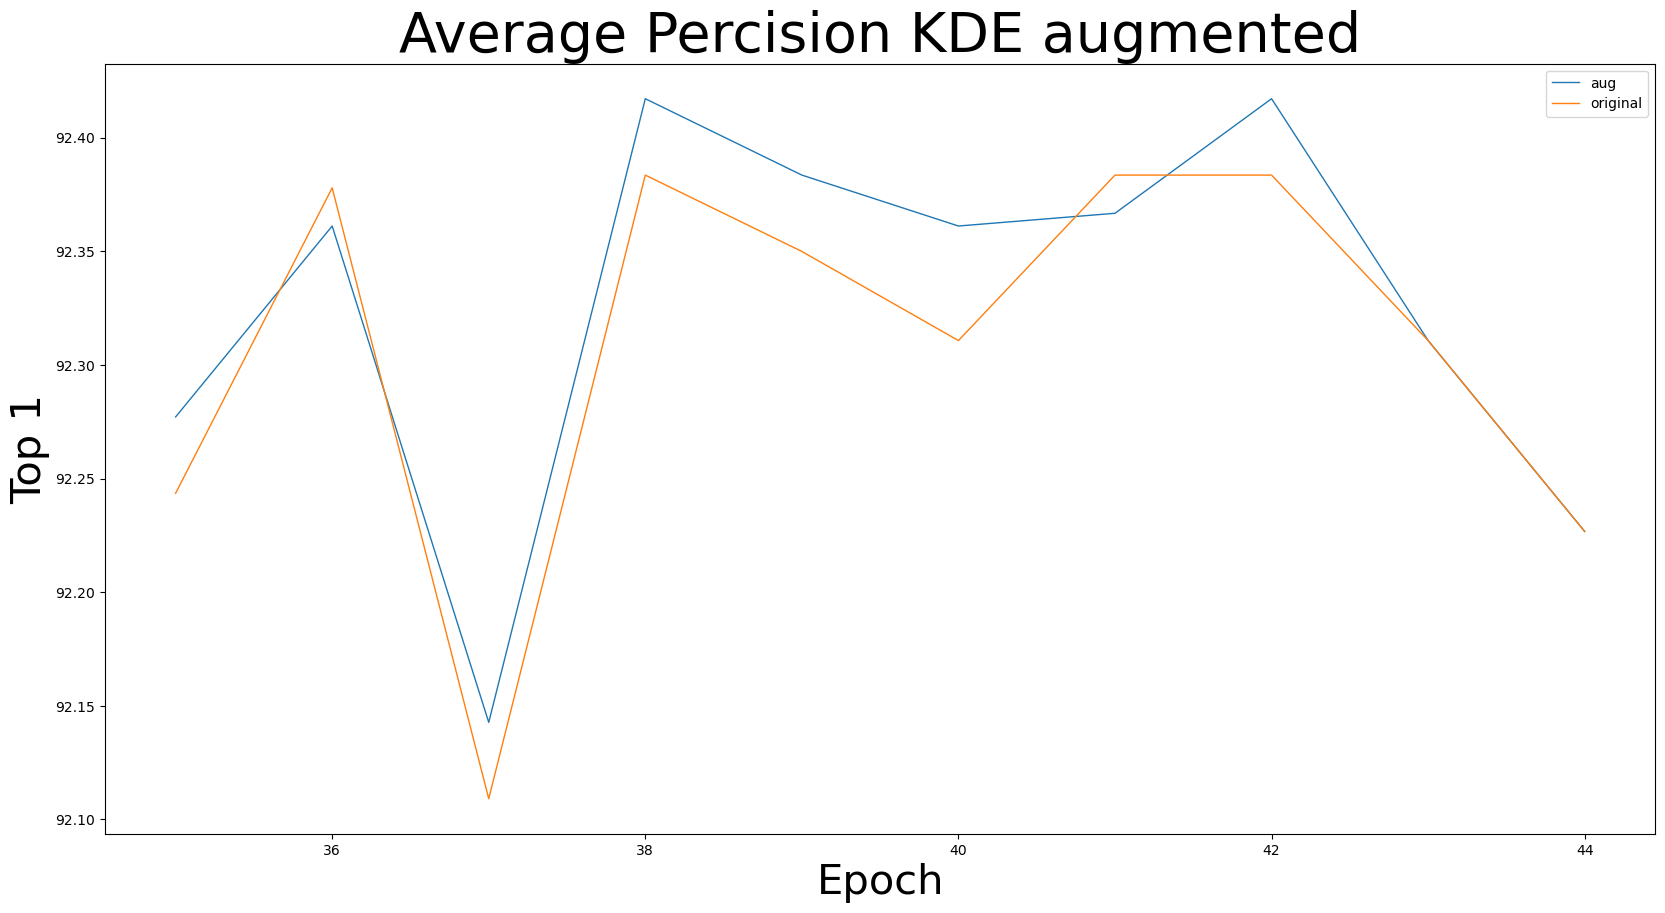

In [215]:
plt.figure(figsize=(20,10))
x = [i for i in range(len(prec1_avg_list_aug))]
# plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 20, color = 'r', label = 'axvline - full height')
# plt.xticks(xticks,fontsize=xticks_size)
# plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 1', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision KDE augmented', fontsize=title_size)
linewidth =1
# plt.margins(0)
# plt.xlim([0, max_e])
# plt.ylim([0, 100])

plt.plot(x[-10:],np.array(prec1_avg_list_aug)[-10:], linewidth = linewidth, label = "aug")
plt.plot(x[-10:],np.array(prec1_avg_list)[-10:], linewidth = linewidth, label = "original")
plt.legend() 


In [149]:
prec1_avg_list

[92.2267,
 92.2267,
 92.31071,
 92.32751,
 92.31071,
 92.31071,
 92.32751,
 92.32751,
 92.34431,
 92.34431,
 92.36111,
 92.36111,
 92.39471,
 92.39471,
 92.39471,
 92.39471,
 92.39471,
 92.428314,
 92.445114,
 92.428314,
 92.37791]

In [99]:
knn_outputs
import random
from tqdm import tqdm
import imblearn
import warnings
from scipy.stats import norm
from sklearn.neighbors import KNeighborsClassifier

# knn_smote_n_1000_batch0_cofiguration0

n_list = [100,200,500,1000,1500,2000,2500,3000]
n=0
config =[0,1,2]


random.seed(10)
names_mapping = []
index_mapping = []
for i in range(3):
    random.shuffle(indexes)
    names_mapping.append({science_name : index for (science_name,index) in zip(science_names,indexes)})
    index_mapping.append({index : science_name for (science_name,index) in zip(science_names,indexes)})

i=0
for b in range(max_b+1):
    # for i in config:
        load_tensor =torch.load( f'saved_output/{model_name}_validating_output/knn_smote_n_{n_list[n]}_batch{b}_cofiguration{i}')
        # output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        # target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        print(load_tensor)
        break
        

[[0.15912526 0.15904423 0.1590746  ... 0.15903906 0.15902411 0.        ]
 [0.1590817  0.15906428 0.15913546 ... 0.15905421 0.15904464 0.15906959]
 [0.15907687 0.15901614 0.15896195 ... 0.15906912 0.15903046 0.15892604]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [126]:
#copied from Kevin Barnes/kbarnes3: https://gist.github.com/kbarnes3/3fb7d353e9bdd3efccd5

import ctypes
import platform

ES_CONTINUOUS = 0x80000000
ES_SYSTEM_REQUIRED = 0x00000001


def _set_thread_execution(state):
    ctypes.windll.kernel32.SetThreadExecutionState(state)


def prevent_standby():
    if platform.system() == 'Windows':
        _set_thread_execution(ES_CONTINUOUS | ES_SYSTEM_REQUIRED)


def allow_standby():
    if platform.system() == 'Windows':
        _set_thread_execution(ES_CONTINUOUS)


def long_running(func):
    def inner(*args, **kwargs):
        prevent_standby()
        result = func(*args, **kwargs)
        allow_standby()
        return result
    return inner


In [128]:
def sample_plant_position(plant,df,index):
    if type(plant) == str:
        return dat[dat['Vitenskapelig navn'] == plant].sample(1)
    elif type(plant) == int:
        return dat[dat['Vitenskapelig navn'] == index_mapping[index][plant]].sample(1)


def get_knn_classifier_smote(samples_pos_list,dat,n_list,configuration):
    i = configuration
    sample_pos_indexes = [sp.index[0] for sp in samples_pos_list if sp.index[0] in list(dat.index)]
    
    dat_removed_samples = dat.drop(index=sample_pos_indexes)
    category = []
    for k in dat_removed_samples['Vitenskapelig navn']:
        category.append(names_mapping[i][k])
        
    category = np.array(category)
    points_np= np.array(list(dat_removed_samples['points']))
    oversample = imblearn.over_sampling.KMeansSMOTE()
    warnings.filterwarnings("ignore")
    X, y = oversample.fit_resample(points_np, category) 
    warnings.filterwarnings("default")
    neigh=[]
    for n in n_list:
        neigh.append(KNeighborsClassifier(n_neighbors=n))
    for knn in neigh:
        knn.fit(X, y)
    return neigh

@long_running
def knn_smote_samples_output(batch,n_list):
    # for e in range(1):#max_e+1):
    for b in tqdm(range(max_b+1)):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        sample_pos_list=[]
        weight_tensors = [] 
        if b >= batch: 
            for i in tqdm(range(3)):
                random.seed(11)
                sample_pos_list = []
                # if b>=batch and i !=configuration:

                for j in range(output.size(0)):
                    sample_pos = sample_plant_position(int(target[j]),dat,i)

                    sample_pos_list.append(sample_pos)
                # print(len(sample_pos_list))
                knns = get_knn_classifier_smote(sample_pos_list,dat,n_list,i)
                weight_tensor_knn = np.zeros((output.size(0),185))
                
                for n in range(len(n_list)):
                    weight_tensor_knn = np.zeros((output.size(0),185))
                    
                    for j, sample_pos in enumerate(sample_pos_list):
                        weight_tensor_knn[j]=knns[0].predict_proba(list(sample_pos['points']))

                    weight_tensor_knn = torch.from_numpy(weight_tensor_knn)
                    torch.save(weight_tensor_knn,f'saved_output/{model_name}_validating_output/knn_smote_n_{n_list[n]}_batch{b}_cofiguration{i}')

                    # return weight_tensor_knn,sample_pos_list
                    
knn_smote_samples_output(6,n_list)

 13%|██████████▏                                                                    | 12/93 [54:57<6:10:56, 274.78s/it]


KeyboardInterrupt: 

In [98]:
len(a[1])

64

In [109]:
load_tensor[44]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [120]:
load_tensor =torch.load(f'saved_output/{model_name}_validating_output/{knn_outputs[300]}')

In [122]:
load_tensor[11]

array([0.15906851, 0.15908196, 0.15906711, 0.15906927, 0.15905904,
       0.15906043, 0.15906253, 0.        , 0.15908187, 0.15906829,
       0.15907666, 0.15906931, 0.1590778 , 0.15908004, 0.159019  ,
       0.        , 0.15907375, 0.15908366, 0.15909192, 0.15906244,
       0.15910862, 0.15908025, 0.15905803, 0.15904335, 0.15905571,
       0.15900796, 0.15903329, 0.15907127, 0.15906918, 0.15908828,
       0.15902989, 0.15904521, 0.1590516 , 0.15905647, 0.15908248,
       0.15907098, 0.15905846, 0.15911862, 0.15909361, 0.15905752,
       0.1590683 , 0.15906711, 0.15904964, 0.15906561, 0.        ,
       0.15905899, 0.15903603, 0.15908262, 0.15902576, 0.15909285,
       0.        , 0.1590669 , 0.15909791, 0.15908031, 0.15906748,
       0.        , 0.15910574, 0.        , 0.15910279, 0.15908022,
       0.15908805, 0.15906314, 0.15910485, 0.159108  , 0.15902797,
       0.15901055, 0.15907377, 0.15905592, 0.15907407, 0.15906941,
       0.15908063, 0.15914399, 0.15907214, 0.        , 0.15903